## DATA 558: Take Home Midterm

Geoffrey Li

May 19, 2019

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import datetime
import random

## Exercise 2: Data Competition Project

### 2.1: Define Functions

Using functions as defined in Exercise 1.

In [50]:
def computegrad(x, y, beta, lamb, rho):
    p = np.identity(len(x)) - np.diag(1/(1+np.exp(np.multiply(-rho*y, x@beta))).reshape(1, -1)[0])
    return -1/len(x) * x.T @ p @ y + 2*lamb*beta


def computeobj(x, y, beta, lamb, rho):
    return 1/(len(x)*rho)*np.sum(np.log(1+np.exp(np.multiply(-rho*y, x@beta)))) + lamb*np.sum(beta**2)


def backtracking(curr_beta, lamb, x, y, rho, eta_t=1, alpha=0.5, gamma=0.5, max_iter=100):
    grad_curr_beta = computegrad(x, y, curr_beta, lamb, rho)  # Gradient at current beta
    norm_grad_curr_beta = np.sqrt(np.sum(grad_curr_beta ** 2))  # Norm of the gradient at current beta
    found_eta_t = False
    i = 0  # Iteration counter

    while (found_eta_t is False and i < max_iter):
        if (computeobj(x, y, curr_beta - eta_t * grad_curr_beta, lamb, rho) <
                computeobj(x, y, curr_beta, lamb, rho) - alpha * eta_t * norm_grad_curr_beta ** 2):
            found_eta_t = True
        elif i == max_iter - 1:
            raise ('Maximum number of iterations of backtracking reached')
        else:
            eta_t *= gamma
            i += 1

    return eta_t


def initstepsize(x, lamb):
    return 1/(max(np.linalg.eigh(1/len(x)*x.T@x)[0]) + lamb)


# def graddescent(beta_init, lamb, x, y, rho, ss_init, targ_acc):
#     beta_values = list()
#     beta_values.append(beta_init)

#     grad_beta = computegrad(x, y, beta_init, lamb, rho)
#     norm_grad_beta = np.sqrt(np.sum(grad_beta ** 2))
#     tuned_step_size = ss_init

#     t = 0

#     while norm_grad_beta > targ_acc:
#         tuned_step_size = backtracking(beta_values[t], lamb, x, y, rho, 
#                                        eta_t=tuned_step_size, alpha=0.5, gamma=0.8, max_iter=100)
#         beta_values.append(beta_values[t] - tuned_step_size * grad_beta)

#         t += 1

#         grad_beta = computegrad(x, y, beta_values[t], lamb, rho)
#         norm_grad_beta = np.sqrt(np.sum(grad_beta ** 2))

#     return beta_values


def fastgradalgo(beta_init, lamb, x, y, rho, theta_init, ss_init, targ_acc):
    beta_values = list()
    beta_values.append(beta_init)
    theta = theta_init

    grad_theta = computegrad(x, y, theta, lamb, rho)

    grad_beta = computegrad(x, y, beta_init, lamb, rho)
    norm_grad_beta = np.sqrt(np.sum(grad_beta ** 2))

    tuned_step_size = ss_init

    t = 0

    while norm_grad_beta > targ_acc:
        grad_theta = computegrad(x, y, theta, lamb, rho)

        tuned_step_size = backtracking(beta_values[t], lamb, x, y, rho, 
                                       eta_t=tuned_step_size, alpha=0.5, gamma=0.8, max_iter=100)

        beta_values.append(theta - tuned_step_size * grad_theta)
        theta = beta_values[t + 1] + (t / (t + 3)) * (beta_values[t + 1] - beta_values[t])

        t += 1

        grad_beta = computegrad(x, y, beta_values[t], lamb, rho)
        norm_grad_beta = np.sqrt(np.sum(grad_beta ** 2))

    return beta_values


def misclassificationerror(y, x, b):
    return 1 - np.mean(
        np.fromiter(map(lambda p: 1 if p >= 0.5 else -1, 1/(1+np.exp(-x@b))), 
                    dtype=np.int).reshape(-1,1) == y)

def misclassificationerror_transform(y, x, b, pos_class, neg_class):
    return 1 - np.mean(
        np.fromiter(map(lambda p: pos_class if p >= 0.5 else neg_class, 1/(1+np.exp(-x@b))), 
                    dtype=np.int) == y)

In [4]:
def myrhologistic(x_train, y_train, init_eta, target_accuracy, rho, lamb):
    init_beta = np.zeros(x_train.shape[1])[:, np.newaxis]
    init_theta = np.zeros(x_train.shape[1])[:, np.newaxis]
    
    # Run fast gradient and train classifier
    beta_opt = fastgradalgo(init_beta, lamb, x_train, y_train, rho, init_theta, init_eta, target_accuracy)
    beta_opt_T = beta_opt[len(beta_opt)-1]
    
    return beta_opt_T

In [5]:
def crossval(x, y, testsetsize, params, targ_acc, rho):
    # testsetsize denotes percentage of training data to be split as test data (e.g. 0.20 is 80/20 split)
    # testsetsize = 1 indicates leave-one-out CV
    
    n = len(x)
    cv_results = dict()
    errors = list()
    
    if testsetsize == 1: #leave-one-out CV
        for l in params:
            print('Start CV for Lambda = '+str(l))
            eta_init = initstepsize(x, l)
            errors = list()
            
            for i in range(n):
                cv_x_test = x[i,:]
                cv_y_test = y[i,:]
                cv_x_train = np.delete(x, i, 0)
                cv_y_train = np.delete(y, i, 0)

                beta_T = myrhologistic(cv_x_train, cv_y_train, eta_init, targ_acc, rho, l)
                errors.append(misclassificationerror(cv_y_test, cv_x_test, beta_T))
#                 print('LOO CV Iteration '+str(i)+' complete.')
            
            cv_results[l] = np.mean(errors)
    elif testsetsize > 0 and testsetsize < 1:
        testset_idx = random.sample(range(n), int(n*testsetsize)) # Generate random test set indices
        cv_x_test = x[testset_idx,:]
        cv_y_test = y[testset_idx,:]
        cv_x_train = np.delete(x, testset_idx, 0)
        cv_y_train = np.delete(y, testset_idx, 0)
        
        for l in params:
            eta_init = initstepsize(x, l)
            
            beta_T = myrhologistic(cv_x_train, cv_y_train, eta_init, targ_acc, rho, l)
            cv_results[l] = misclassificationerror(cv_y_test, cv_x_test, beta_T)
            
    else:
        raise('Invalid test set size.')
    
    return min(cv_results, key=cv_results.get), cv_results

### 2.2: Loading and processing data

In [6]:
path = './compdata/'

In [7]:
X_train = np.load(path+'train_features.npy')
y_train = np.load(path+'train_labels.npy')

X_val = np.load(path+'val_features.npy')
y_val = np.load(path+'val_labels.npy')

X_test = np.load(path+'test_features.npy')

In [8]:
# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
# Subsets training and validation data based on input classes
def subset_data(pos_class, neg_class, X_train, y_train, X_val, y_val):
    train_subset = (y_train == pos_class) | (y_train == neg_class)
    val_subset = (y_val == pos_class) | (y_val == neg_class)

    y_train_subset = y_train[np.where(train_subset)]
    X_train_subset = X_train[train_subset.nonzero()[0]]

    y_val_subset = y_val[np.where(val_subset)]
    X_val_subset = X_val[val_subset.nonzero()[0]]
    
    y_train_subset = np.fromiter(map(lambda n: 1 if n == pos_class else -1, y_train_subset), dtype=int).reshape(-1, 1)
    y_val_subset = np.fromiter(map(lambda n: 1 if n == pos_class else -1, y_val_subset), dtype=int).reshape(-1, 1)
    
    return X_train_subset, y_train_subset, X_val_subset, y_val_subset

### 2.3: Training model with default params

Pick two classes of your choice from the dataset. Train a classifier using l2-regularized binary logistic regression with ρ-logistic loss on the training set using your own accelerated gradient algorithm with ρ = 2, ε = 10−3, and λ = 1. Be sure to use the features you previously generated with the provided script rather than the raw image features. 

First two arguments in the subset_data() function indicate the positive and negative class respectively. In this first exercise we'll choose pos_class = 1 and neg_class = 0.

In [10]:
X_train_subset, y_train_subset, X_val_subset, y_val_subset = subset_data(1, 0, X_train, y_train, X_val, y_val)

In [11]:
# Initialize fast gradient
init_beta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
init_theta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
lambduh = 1
target_accuracy = 10**-3
r = 2
init_eta = initstepsize(X_train_subset, lambduh)

# Train classifier
beta_opt_naive = fastgradalgo(init_beta, lambduh, X_train_subset, y_train_subset, r, 
                              init_theta, init_eta, target_accuracy)



Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.


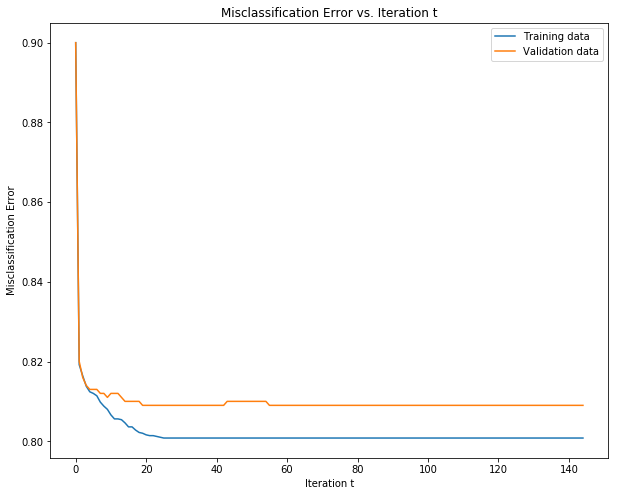

In [51]:
# Plot misclassification error
plt.figure(figsize=(10,8))
plt.plot(range(0,len(beta_opt_naive)),
         list(map(lambda b: misclassificationerror_transform(y_train,X_train,b,1,0),beta_opt_naive)))
plt.plot(range(0,len(beta_opt_naive)),
         list(map(lambda b: misclassificationerror_transform(y_val,X_val,b,1,0),beta_opt_naive)))
plt.legend(['Training data', 'Validation data'], loc='upper right')
plt.title('Misclassification Error vs. Iteration t')
plt.xlabel('Iteration t')
plt.ylabel('Misclassification Error');

As expected, the misclassification error rate approaches 0.8 for the Training data (we only picked 2 classes to train on). For the Validation data, it performs slightly worse as we are using unseen data.

### 2.4a: Training model with 80/20 Hold-Out CV

Find the value of the regularization parameter λ using using hold-out cross-validation. Train a classifier using l2-regularized binary logistic regression with ρ-logistic loss on the training set using your own accelerated gradient algorithm with that value of λ found by hold-out cross-validation.

In [13]:
X_train_subset, y_train_subset, X_val_subset, y_val_subset = subset_data(1, 0, X_train, y_train, X_val, y_val)

In [14]:
# Initialize fast gradient
init_beta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
init_theta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
target_accuracy = 10**-3
r = 2
test_set_fraction = 0.20
lambs = [10**i for i in range(2, -3, -1)]

# Run CV to find optimal lambda
opt_lamb, cv_res_holdout = crossval(X_train_subset, y_train_subset, test_set_fraction, lambs, target_accuracy, r)
init_eta = initstepsize(X_train_subset, opt_lamb)


# Train classifier
beta_opt_holdout = fastgradalgo(init_beta, opt_lamb, X_train_subset, y_train_subset, r, 
                                init_theta, init_eta, target_accuracy)

In [55]:
# Lambda found using hold-out CV
print(opt_lamb)

0.1


Plot, with different colors, the misclassification error on the training set and on the validation set vs. iterations.

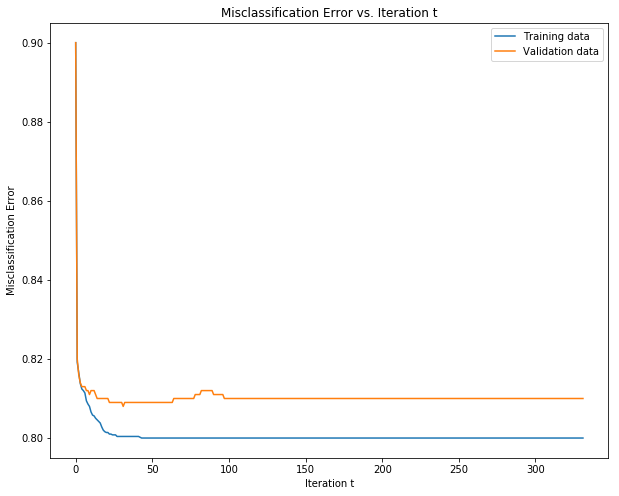

In [53]:
# Plot misclassification error
plt.figure(figsize=(10,8))
plt.plot(range(0,len(beta_opt_holdout)),
         list(map(lambda b: misclassificationerror_transform(y_train,X_train,b,1,0),beta_opt_holdout)))
plt.plot(range(0,len(beta_opt_holdout)),
         list(map(lambda b: misclassificationerror_transform(y_val,X_val,b,1,0),beta_opt_holdout)))
plt.legend(['Training data', 'Validation data'], loc='upper right')
plt.title('Misclassification Error vs. Iteration t')
plt.xlabel('Iteration t')
plt.ylabel('Misclassification Error');

As expected, the misclassification error rate approaches 0.8 for the Training data (we only picked 2 classes to train on). For the Validation data, it performs slightly worse as we are using unseen data.

### 2.4b: Training model with Leave-One-Out CV

Find the value of the regularization parameter λ using using leave-one-out cross-validation.

In [ ]:
X_train_subset, y_train_subset, X_val_subset, y_val_subset = subset_data(1, 0, X_train, y_train, X_val, y_val)

In [ ]:
# Initialize fast gradient
init_beta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
init_theta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
target_accuracy = 10**-3
r = 2
test_set_fraction = 1 #LOO CV
lambs = [10**i for i in range(2, -3, -1)]

# Run CV to find optimal lambda
opt_lamb, cv_res_loo = crossval(X_train_subset, y_train_subset, test_set_fraction, lambs, target_accuracy, r)
init_eta = initstepsize(X_train_subset, opt_lamb)


# Train classifier
beta_opt_loo = fastgradalgo(init_beta, opt_lamb, X_train_subset, y_train_subset, r, 
                                init_theta, init_eta, target_accuracy)

In [56]:
# Lambda found using LOO CV
print(opt_lamb)

0.1


### 2.5: Training pairwise models with 80/20 Holdout CV

Consider all pairs of classes from the dataset. For each pair of classes, train a classifier using a l2-regularized binary logistic regression with ρ-logistic loss on the training set comprising only the data-points for that pair of classes using your own fast gradient algorithm. For each pair of classes, find the value of the regularization parameter λ using hold-out cross-validation on the training set comprising only the data-points for that pair of classes.

In [ ]:
# Initialize fast gradient
init_beta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
init_theta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
target_accuracy = 10**-3
r = 2
test_set_fraction = 0.20
lambs = [10**i for i in range(-4, 3)]
opt_lamb_pairwise = list()

# Store trained beta values in a list of length 45, one entry for each pairwise classifier
pairwise_clfs = dict()

for i in range(10):
    for j in range(i+1, 10):
        print('Training ('+str(i)+','+str(j)+') model...')
        X_train_subset, y_train_subset, X_val_subset, y_val_subset = subset_data(i, j, X_train, y_train, X_val, y_val)
        
        # Run CV to find optimal lambda
        opt_lamb, cv_res_pairwise = crossval(X_train_subset, y_train_subset, test_set_fraction, lambs, 
                                            target_accuracy, r)
        opt_lamb_pairwise.append(opt_lamb)
        init_eta = initstepsize(X_train_subset, opt_lamb)
        
        # Train classifier
        beta_opt_pairwise = fastgradalgo(init_beta, opt_lamb, X_train_subset, y_train_subset, r, 
                                         init_theta, init_eta, target_accuracy)
        
        pairwise_clfs[(i, j)] = beta_opt_pairwise[len(beta_opt_pairwise)-1]

                

In [88]:
c = 0
for i in range(10):
    for j in range(i+1, 10):
        print('('+str(i)+','+str(j)+') Model Optimal Lambda: '+str(opt_lamb_pairwise[c]))
        c += 1

(0,1) Model Optimal Lambda: 0.0001
(0,2) Model Optimal Lambda: 0.01
(0,3) Model Optimal Lambda: 1
(0,4) Model Optimal Lambda: 0.01
(0,5) Model Optimal Lambda: 0.0001
(0,6) Model Optimal Lambda: 0.0001
(0,7) Model Optimal Lambda: 0.0001
(0,8) Model Optimal Lambda: 0.0001
(0,9) Model Optimal Lambda: 0.001
(1,2) Model Optimal Lambda: 0.1
(1,3) Model Optimal Lambda: 1
(1,4) Model Optimal Lambda: 1
(1,5) Model Optimal Lambda: 10
(1,6) Model Optimal Lambda: 0.001
(1,7) Model Optimal Lambda: 0.1
(1,8) Model Optimal Lambda: 0.0001
(1,9) Model Optimal Lambda: 0.0001
(2,3) Model Optimal Lambda: 1
(2,4) Model Optimal Lambda: 0.01
(2,5) Model Optimal Lambda: 0.0001
(2,6) Model Optimal Lambda: 1
(2,7) Model Optimal Lambda: 0.0001
(2,8) Model Optimal Lambda: 1
(2,9) Model Optimal Lambda: 1
(3,4) Model Optimal Lambda: 1
(3,5) Model Optimal Lambda: 0.0001
(3,6) Model Optimal Lambda: 1
(3,7) Model Optimal Lambda: 0.0001
(3,8) Model Optimal Lambda: 0.0001
(3,9) Model Optimal Lambda: 0.1
(4,5) Model Opti

### 2.6: Predicting using pairwise classifiers

Write a function that for any new data point predicts its label. To do this, you will perform the following: input the data point into each classifier (for each pair of classes) you trained above. Record the class predicted by each classifier. Then your prediction for this data point is the most frequently predicted class. If there is a tie, randomly choose between the tied classes.

In [ ]:
def majority_vote(array):
    most = max(list(map(array.count, array)))
    return random.choice(list(set(filter(lambda x: array.count(x) == most, array))))

In [ ]:
def predict_pairwise(betas, x):
    preds = list(map(lambda p: p[0] if 1/(1+np.exp(-x@betas[p])) > 0.5 else p[1], betas))
    return majority_vote(preds)

Report the misclassification error on the validation set and test set.

In [57]:
# Validation set predictions
y_val_preds = list(map(lambda n: predict_pairwise(pairwise_clfs, n), X_val))

# Misclassification Error Rate for Validation Set
1 - np.mean(y_val_preds == y_val)

0.241

In [ ]:
# Test set predictions
y_test_preds = list(map(lambda n: predict_pairwise(pairwise_clfs, n), X_test))

# Write to CSV for Kaggle submission
pd.DataFrame({'Category':y_test_preds}).reset_index()\
             .rename(columns={'index':'Id'}).to_csv('./y_test_preds_power10lamb_expand.csv', index=False)

In [58]:
# From Kaggle
# Misclassification Error Rate for Test Set
1 - 0.73

0.27

Report the precision/recall on the validation set.

In [79]:
def prec_rec(pos_class, y_pred, y_actual):
    true_pos = len(y_pred[np.where(y_actual == pos_class)][
        np.where(y_pred[np.where(y_actual == pos_class)] == pos_class)])
    false_neg = len(y_pred[np.where(y_actual == pos_class)][
        np.where(y_pred[np.where(y_actual == pos_class)] != pos_class)])
    true_neg = len(y_val_preds[np.where(y_val != pos_class)][
        np.where(y_val_preds[np.where(y_val != pos_class)] != pos_class)])
    false_pos = len(y_val_preds[np.where(y_val != pos_class)][
        np.where(y_val_preds[np.where(y_val != pos_class)] == pos_class)])
    
    precision = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    
    return precision, recall

In [70]:
y_val_preds = np.fromiter(y_val_preds, dtype=np.int)

In [82]:
for i in range(10):
    print('Positive Class = '+str(i))
    prec, rec = prec_rec(i, y_val_preds, y_val)
    print('Precision: '+str(prec)+', Recall: '+str(rec))
    print('')

Positive Class = 0
Precision: 0.7889908256880734, Recall: 0.86

Positive Class = 1
Precision: 0.7142857142857143, Recall: 0.75

Positive Class = 2
Precision: 0.7314814814814815, Recall: 0.79

Positive Class = 3
Precision: 0.7021276595744681, Recall: 0.66

Positive Class = 4
Precision: 0.7692307692307693, Recall: 0.7

Positive Class = 5
Precision: 0.7884615384615384, Recall: 0.82

Positive Class = 6
Precision: 0.6804123711340206, Recall: 0.66

Positive Class = 7
Precision: 0.7857142857142857, Recall: 0.77

Positive Class = 8
Precision: 0.819047619047619, Recall: 0.86

Positive Class = 9
Precision: 0.8089887640449438, Recall: 0.72

